## HW1-1 Image Classification：

# Set up environment

In [ ]:
!pip install --upgrade gdown tqdm transformers==4.21.3 timm==0.6.7 scikit-learn==1.1.2 pandas einops imageio==2.21.2 matplotlib==3.5.3 numpy==1.23.1 Pillow==9.2.0 scipy==1.9.1 torch==1.12.1 torchvision==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 36.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 47.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 82.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 65.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 25.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 939.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# About the Dataset

In [ ]:
'''
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip
'''
# Download dataset
!gdown 1owVOM3V94bC8v2N8s7n56ciVzVbSzYtd -O hw1_data.zip
'''
!gdown 是一個命令，通常用於從 Google Drive 下載文件。
1owVOM3V94bC8v2N8s7n56ciVzVbSzYtd 是 Google Drive 分享鏈接中文件的唯一標識符，指定了要下載的文件。
-O hw1_data.zip 指定了下載的文件應該被保存為 "hw1_data.zip"，這是您指定的新文件名。
'''

# Unzip the downloaded zip file
# This may take some time.
!unzip -q ./hw1_data.zip

# Import Packages

Downloading...
From (uriginal): https://drive.google.com/uc?id=1owVOM3V94bC8v2N8s7n56ciVzVbSzYtd
From (redirected): https://drive.google.com/uc?id=1owVOM3V94bC8v2N8s7n56ciVzVbSzYtd&confirm=t&uuid=8832b6b2-80a3-4d5a-aaa1-0fb660ea270c
To: /kaggle/working/hw1_data.zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:04<00:00, 269MB/s]


In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image #PIL包含在pillow這個函式庫
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm import tqdm
import random
import timm
# packages for inceptionnext model
from functools import partial
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import checkpoint_seq
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model
from timm.models.layers.helpers import to_2tuple

In [ ]:
# set a random seed for reproducibility
myseed = 6666
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for this recognition of this task.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), #影像 RandomHorizontalFlip 和 RandomVerticalFlip
    # transforms.RandomResizedCrop(32,scale=(0.08, 1.0)),#影像 RandomCrop:torchvision.transforms.RandomCrop(size(寬度和高度，可以為一個值), padding=None, pad_if_needed=False, fill=0, padding_mode='constant')
    #影像 GaussianBlur:torchvision.transforms.GaussianBlur(kernel_size(模糊半徑，必須是奇數), sigma（高斯kernel生成的標準差，須為固定值在設定的float值或是在（min,max）內）=(0.1,.2))(img)，半徑和標準差越大照片越模糊
    transforms.RandomRotation(30),#影像 RandomRotation:torchvision.transforms.RandomRotation(degrees（如 30，则表示在（-30，+30）之间随机旋转
    # 若为sequence，如(30，60)，则表示在30-60度之间随机旋转）, resample=False(resample- 重采样方法选择，可选 PIL.Image.NEAREST, PIL.Image.BILINEAR), expand=False, center=None:以圖的正中心旋轉)，
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
    # You may add some transforms here!!!!!!!!!!!! https://blog.csdn.net/qq_42951560/article/details/109852790
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.ToTensor(),
])

# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [ ]:
class hw1_1Dataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(hw1_1Dataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".png")])
        if files != None:
            self.files = files

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx] # fname = ./hw1_data/p1_data/train_50/31_327.png
        im = Image.open(fname)
        im = self.transform(im)

        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label


# Create Model

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Configurations

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 50

# Initialize a model, and put it on the device specified.
model_A = models.resnet50(pretrained=False)
in_features = model_A.fc.in_features
model_A.fc = torch.nn.Linear(in_features, num_classes)

model_B = inceptionnext_tiny(pretrained=True) # can change different model name

model_C = models.resnet50(pretrained=True)
in_features = model_C.fc.in_features
model_C.fc = torch.nn.Linear(in_features, num_classes)


model_D = timm.create_model('convnext_base_in22ft1k', pretrained=True, num_classes=50)

model_E = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x1_4", pretrained=True)
in_features = model_E.classifier[1].in_features
model_E.classifier[1] = torch.nn.Linear(in_features, num_classes)


model = model_E
model.to(device)

# The number of batch size.
batch_size = 256

# The number of training epochs.
n_epochs = 200

# weight decay
wd_num = 0.00001

# MixUp alpha(α \alphaα在0.2 ~ 2之間效果都差不多，表示mixup對α \alphaα參數並不是很敏感。但如果α \alphaα過小，等於沒有進行mixup的原始數據，如果α \alphaα過大，等於所有輸入都是各取一半混合)
alpha = 0

# If no improvement in 'patience' epochs, early stop.
patience = 20

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=wd_num)

ckpt_name = "cifar100_mobilenetv2_x1_4_exp2_best.ckpt"
ckpt_first_name = "cifar100_mobilenetv2_x1_4_exp2_first.ckpt"
ckpt_middle_name = "cifar100_mobilenetv2_x1_4_exp2_middle.ckpt"
ckpt_last_name = "cifar100_mobilenetv2_x1_4_exp2_last.ckpt"

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/sail-sg/inceptionnext/releases/download/model/inceptionnext_tiny.pth" to /root/.cache/torch/hub/checkpoints/inceptionnext_tiny.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_224.pth
/opt/conda/lib/python3.10/site-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobi

  0%|          | 0.00/17.4M [00:00<?, ?B/s]

### Dataloader(Use MixUp and CutMix)
Where to use MixUp and CutMix: After the DataLoader
The simplest way to do this is right "after the DataLoader": the Dataloader has already batched the images and labels for us, and this is exactly what these transforms expect as input:

In [ ]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = hw1_1Dataset("./hw1_data/p1_data/train_50", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = hw1_1Dataset("./hw1_data/p1_data/val_50", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Start Training

In [ ]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, targets_a, targets_b, lam = mixup_data(imgs, labels, alpha)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        # loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if (epoch+1)==1:
        print(f"middle model found at epoch {epoch+1}, val acc is {valid_acc}, saving model")
        torch.save(model.state_dict(), ckpt_first_name)

    if (epoch+1)==10:
        print(f"middle model found at epoch {epoch+1}, val acc is {valid_acc}, saving model")
        torch.save(model.state_dict(), ckpt_middle_name)

    # update logs
    if valid_acc > best_acc:
        with open("./sample_best_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open("./sample_best_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # save models
    if valid_acc > best_acc:
        best_epoch = epoch+1
        print(f"Best model found at epoch {best_epoch}, saving model")
        torch.save(model.state_dict(), ckpt_name) # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping at no.{epoch+1} epoch, best epoch at {best_epoch}.")
            torch.save(model.state_dict(), ckpt_last_name)
            break
    if (epoch+1) == n_epochs:
        torch.save(model.state_dict(), ckpt_last_name)

### Dataloader for test

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = hw1_1Dataset("./hw1_data/p1_data/val_50", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Testing and generate prediction CSV

In [ ]:
model_best = model_E
model_best.to(device)
model_best.load_state_dict(torch.load(f'/kaggle/working/{ckpt_name}'))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_pred_np = test_pred.cpu().data.numpy()

        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


In [ ]:
#create test csv
def get_filename(test_path):
    return sorted([x for x in os.listdir(test_path) if x.endswith(".png")])
filename = get_filename('./hw1_data/p1_data/val_50')
df = pd.DataFrame()
df["filename"] = filename
df["label"] = prediction
df.to_csv("submission.csv",index = False)

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output on 3 different epochs(first, middle, last).

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = model_E
model.load_state_dict(torch.load('/kaggle/input/2023dlcv-hw1-1-a/2023dlcv_hw1_1_A/cifar100_mobilenetv2_x1_4_exp2_first.ckpt'))
model.eval()

100%|██████████| 40/40 [00:01<00:00, 28.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2500, 7168)
2500


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


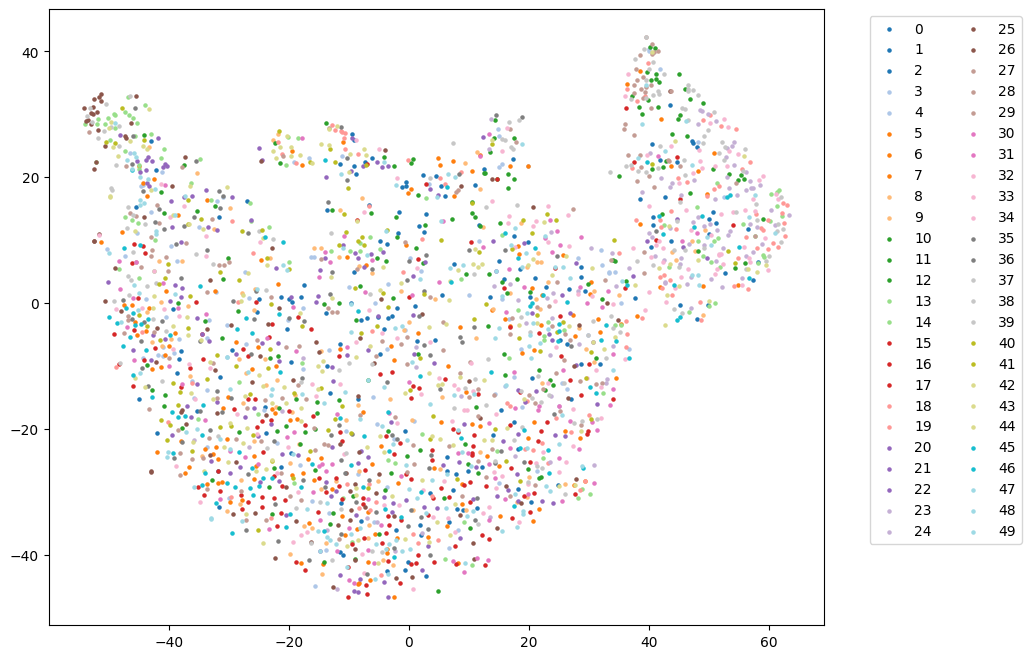

In [ ]:
# Load the vaildation set defined by TA
valid_set = hw1_1Dataset("./hw1_data/p1_data/val_50", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = ... # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.features[:18](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
print(features.shape)
print(len(labels))
colors_per_class = cm.tab20(np.linspace(0, 1, 50))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5, color=colors_per_class[label])

# 移动图例到右上角并分列显示
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 可根据需要更改ncol的值


# 保存图像
plt.savefig('tsne_plot.png')  # 指定图像文件名

plt.show()



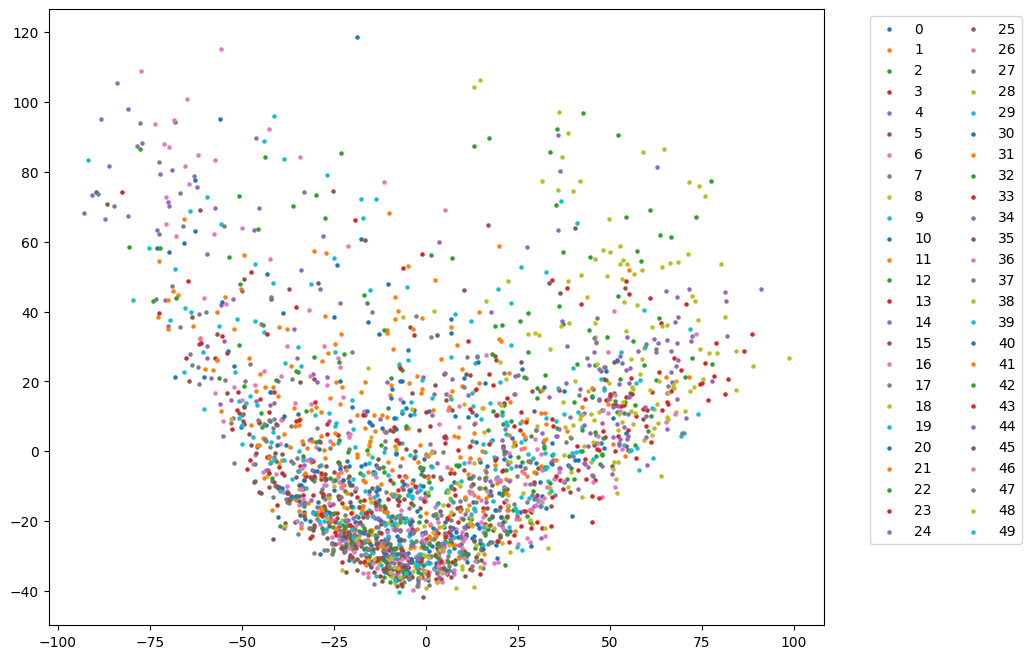

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

# ... 之前的代码 ...

# Apply PCA to the features
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Plot the PCA visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_pca[labels == label, 0], features_pca[labels == label, 1], label=label, s=5)

# 移动图例到右上角并分列显示
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # 可根据需要更改ncol的值

plt.show()

In [ ]:
'''
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load('/kaggle/input/2023mlhw3-exp1/sample_best.ckpt')
model.load_state_dict(state_dict)
model.eval()

print(model)
'''

In [ ]:
'''

# Load the vaildation set defined by TA
valid_set = FoodDataset("/kaggle/input/ml2023spring-hw3/valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 20
# You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
# 12(middel，可以看得到部分圖片),16（Top）,20（Top，可以看到整張圖片），取「MaxPool2d」的輸出，不然參數會太多，RAM不夠用
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
print(len(features))
# array 和 asarray 都可以將 結構資料 轉化為 ndarray，但是主要區別就是當資料來源是ndarray時，array仍然會copy出一個副本，佔用新的記憶體，但asarray不會。
features = np.asarray(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.savefig('layer_16.png')

'''